(i) Impliment Variational Autoencoder (VAE)

In [1]:
# Install required libraries if not already installed
!pip install tensorflow matplotlib numpy

import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.losses import BinaryCrossentropy
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

In [2]:
# Load the MNIST dataset
(x_train, _), (_, _) = mnist.load_data()
x_train = x_train.astype("float32") / 255.0  # Normalize to [0, 1]
x_train = np.expand_dims(x_train, axis=-1)    # Reshape to (28, 28, 1)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
from tensorflow.keras.layers import Lambda, Input, Flatten, Dense, Reshape
from tensorflow.keras.models import Model
import tensorflow as tf

latent_dim = 2  # Dimension of the latent space

# Encoder
def build_encoder():
    inputs = Input(shape=(28, 28, 1))
    x = Flatten()(inputs)
    x = Dense(256, activation="relu")(x)
    z_mean = Dense(latent_dim, name="z_mean")(x)
    z_log_var = Dense(latent_dim, name="z_log_var")(x)
    return Model(inputs, [z_mean, z_log_var], name="encoder")

# Sampling function with Lambda layer
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.keras.backend.random_normal(shape=(tf.shape(z_mean)[0], latent_dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Decoder
def build_decoder():
    latent_inputs = Input(shape=(latent_dim,))
    x = Dense(256, activation="relu")(latent_inputs)
    x = Dense(28 * 28, activation="sigmoid")(x)
    outputs = Reshape((28, 28, 1))(x)
    return Model(latent_inputs, outputs, name="decoder")

# Instantiate encoder and decoder
encoder = build_encoder()
decoder = build_decoder()

# Define the VAE model with Lambda layer for sampling
inputs = Input(shape=(28, 28, 1))
z_mean, z_log_var = encoder(inputs)
z = Lambda(sampling)([z_mean, z_log_var])  # Use Lambda layer for sampling
reconstructed = decoder(z)

# Custom VAE loss layer
class VAELossLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(VAELossLayer, self).__init__(**kwargs)

    def call(self, inputs):
        inputs, reconstructed, z_mean, z_log_var = inputs
        # Reconstruction loss
        reconstruction_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(tf.keras.backend.flatten(inputs), tf.keras.backend.flatten(reconstructed))
        ) * 28 * 28
        # KL Divergence loss
        kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        # Add the combined loss to the model
        self.add_loss(reconstruction_loss + kl_loss)
        return reconstructed

    def compute_output_shape(self, input_shape):
        return input_shape[1]  # output shape same as the shape of `reconstructed`

# Apply the custom loss layer
outputs = VAELossLayer()([inputs, reconstructed, z_mean, z_log_var])
vae = Model(inputs, outputs, name="vae_with_custom_loss")

# Compile VAE with any loss function placeholder (losses are added directly in the model)
vae.compile(optimizer="adam")

# Train the VAE
vae.fit(x_train, x_train, epochs=30, batch_size=128)


Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 248.3429
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 170.4369
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 165.4930
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 162.7889
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 160.4939
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 159.1400
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - loss: 157.8949
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 156.8594
Epoch 9/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 155.7049
Epoch 10/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 155.6389
Epoch 11/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 154.5213
Epoch 12/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 153.8288
Epoch 13/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 153.4945
Epoch 14/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 153.1185
Epoch 15/30

(ii) Implement the GAN

In [12]:
# Generator with Input layer
def build_generator():
    model = Sequential([
        Input(shape=(latent_dim,)),
        Dense(128, activation="relu"),
        BatchNormalization(),
        Dense(256, activation="relu"),
        BatchNormalization(),
        Dense(28 * 28, activation="sigmoid"),
        Reshape((28, 28, 1))
    ])
    return model

# Discriminator with Input layer
def build_discriminator():
    model = Sequential([
        Input(shape=(28, 28, 1)),
        Flatten(),
        Dense(256, activation="relu"),
        Dense(128, activation="relu"),
        Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model


In [13]:
import tensorflow as tf

@tf.function
def train_step(real_imgs, generator, discriminator, gan, batch_size):
    noise = tf.random.normal((batch_size, latent_dim))
    fake_imgs = generator(noise, training=False)

    # Train discriminator on real and fake images
    d_loss_real = discriminator.train_on_batch(real_imgs, tf.ones((batch_size, 1)))
    d_loss_fake = discriminator.train_on_batch(fake_imgs, tf.zeros((batch_size, 1)))
    d_loss = 0.5 * (d_loss_real[0] + d_loss_fake[0])

    # Train generator via GAN
    noise = tf.random.normal((batch_size, latent_dim))
    g_loss = gan.train_on_batch(noise, tf.ones((batch_size, 1)))

    return d_loss, g_loss

def train_gan(epochs=10000, batch_size=64):
    for epoch in range(epochs):
        real_imgs = x_train[np.random.randint(0, x_train.shape[0], batch_size)]
        d_loss, g_loss = train_step(real_imgs, generator, discriminator, gan, batch_size)

        if epoch % 1000 == 0:
            print(f"{epoch} [D loss: {d_loss:.4f}] [G loss: {g_loss:.4f}]")


In [14]:
# Define the GAN generator
def build_generator():
    model = Sequential([
        Dense(128, activation="relu", input_shape=(latent_dim,)),
        BatchNormalization(),
        Dense(256, activation="relu"),
        BatchNormalization(),
        Dense(28 * 28, activation="sigmoid"),
        Reshape((28, 28, 1))
    ])
    return model

# Define the GAN discriminator
def build_discriminator():
    model = Sequential([
        Flatten(input_shape=(28, 28, 1)),
        Dense(256, activation="relu"),
        Dense(128, activation="relu"),
        Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

# Build the generator and discriminator
generator = build_generator()
discriminator = build_discriminator()

# Build the GAN
discriminator.trainable = False  # Freeze the discriminator for the GAN training
gan_input = Input(shape=(latent_dim,))
generated_img = generator(gan_input)
gan_output = discriminator(generated_img)
gan = Model(gan_input, gan_output)
gan.compile(optimizer="adam", loss="binary_crossentropy")

# Training GAN
def train_gan(epochs=100, batch_size=64):
    for epoch in range(epochs):
        # Train the discriminator
        real_imgs = x_train[np.random.randint(0, x_train.shape[0], batch_size)]
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        fake_imgs = generator.predict(noise)

        d_loss_real = discriminator.train_on_batch(real_imgs, np.ones((batch_size, 1)))
        d_loss_fake = discriminator.train_on_batch(fake_imgs, np.zeros((batch_size, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train the generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

        # Print the progress
        if epoch % 1000 == 0:
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100*d_loss[1]:.2f}%] [G loss: {g_loss}]")
train_gan()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
0 [D loss: 0.6535919308662415, acc.: 63.67%] [G loss: [array(0.622916, dtype=float32), array(0.622916, dtype=float32), array(0.7578125, dtype=float32)]]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━

(iii) Visualize the latent space and generated images to understand how well the model captures the data distribution.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 

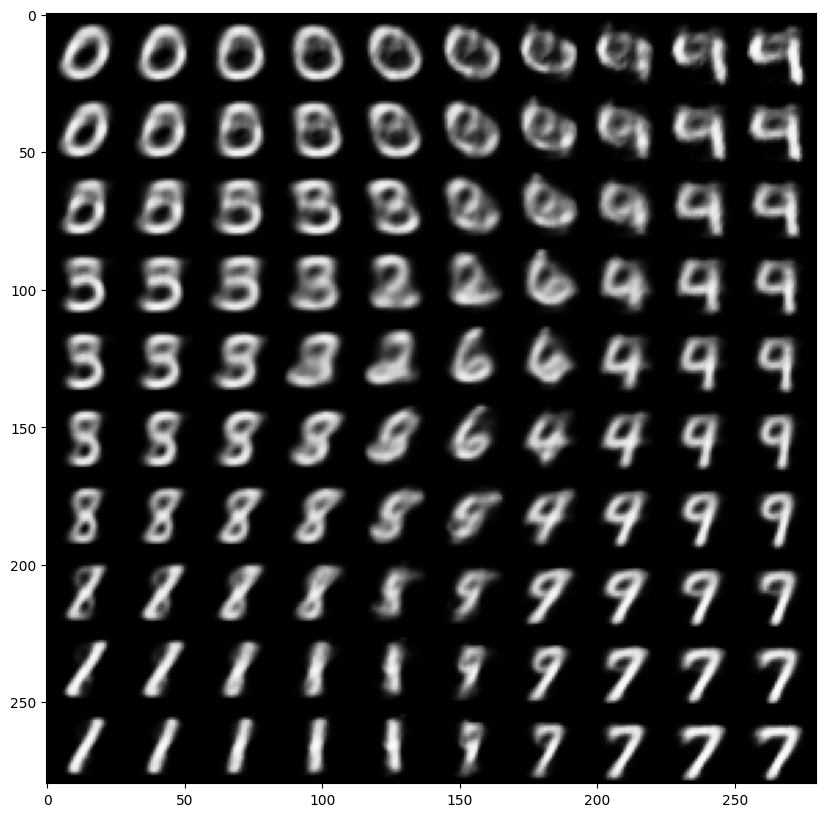

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


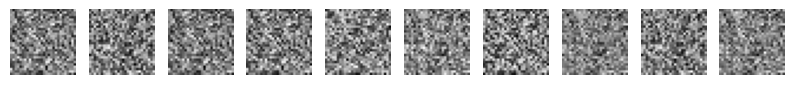

In [15]:
# Visualize VAE latent space
def plot_latent_space(n=10):
    grid_x = np.linspace(-2, 2, n)
    grid_y = np.linspace(-2, 2, n)

    figure = np.zeros((28 * n, 28 * n))
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.array([[xi, yi]])
            generated_img = decoder.predict(z_sample)
            figure[i * 28: (i + 1) * 28, j * 28: (j + 1) * 28] = generated_img[0].reshape(28, 28)
    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

plot_latent_space()

# Visualize GAN generated images
def plot_gan_generated_images(n=10):
    noise = np.random.normal(0, 1, (n, latent_dim))
    generated_images = generator.predict(noise)

    plt.figure(figsize=(10, 10))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(generated_images[i].reshape(28, 28), cmap="gray")
        plt.axis("off")
    plt.show()

plot_gan_generated_images()
